In [1]:
import tensorflow as tf
#import tensorflow.contrib.learn.python.learn as learn
import tflearn 
import scipy as sp
import numpy as np 
import matplotlib.pyplot as plt
from random import shuffle, randint
import pandas as pd
import sklearn
import datetime
%matplotlib inline

# Import and process data

In [48]:
def importData(filepath):
    ppt = np.genfromtxt(filepath)
    dppt = np.diff(np.transpose(ppt)) 
    print("Shape:", dppt[1:16,:].shape)
    return dppt[1:16,:]

illPat0 = importData("./inData/clean_ecg/ill/s0067lre.txt")
illPat1 = importData("./inData/clean_ecg/ill/s0080lre.txt")
illPat2 = importData("./inData/clean_ecg/ill/s0081lre.txt")
illPat3 = importData("./inData/clean_ecg/ill/s0039lre.txt")
illPat4 = importData("./inData/clean_ecg/ill/s0044lre.txt")
illPat5 = importData("./inData/clean_ecg/ill/s0049lre.txt")
illPat6 = importData("./inData/clean_ecg/ill/s0174lre.txt")

healthPat0 = importData("./inData/clean_ecg/health/s0303lre.txt")
healthPat1 = importData("./inData/clean_ecg/health/s0306lre.txt")
healthPat2 = importData("./inData/clean_ecg/health/s0302lre.txt")
healthPat3 = importData("./inData/clean_ecg/health/s0543_re.txt")
healthPat4 = importData("./inData/clean_ecg/health/s0551_re.txt")
healthPat5 = importData("./inData/clean_ecg/health/s0552_re.txt")

# If 0 <= lead < 15, then output that lead number. If lead = 15 output a cat array of all leads.
# If lead = 16 only output Frank leads vx, vy, vz. If lead is anything else output whole dataset flattened.
lead = 12

if 0 <= lead < 15:
    print("Selecting lead", lead)
    healthPat = np.concatenate((healthPat0[lead], healthPat1[lead], healthPat2[lead], \
                                      healthPat3[lead], healthPat4[lead], healthPat5[lead]), axis=0)
    illPat = np.concatenate((illPat0[lead], illPat1[lead], illPat2[lead], illPat3[lead], \
                                   illPat4[lead], illPat5[lead], illPat6[lead]), axis=0)

elif lead == 15:
    print("Outputting array with shape [15, -1]")
    healthPat = np.concatenate((healthPat0, healthPat1, healthPat2, healthPat3, healthPat4, healthPat5), axis=1)
    illPat = np.concatenate((illPat0, illPat1, illPat2, illPat3, illPat4, illPat5, illPat6), axis=1)

elif lead == 16:
    print("Outputing Frank leads")
    healthPat = np.concatenate((healthPat0[12:15], healthPat1[12:15], healthPat2[12:15], \
                                      healthPat3[12:15], healthPat4[12:15], healthPat5[12:15]), axis=1)
    illPat = np.concatenate((illPat0[12:15], illPat1[12:15], illPat2[12:15], illPat3[12:15], \
                                   illPat4[12:15], illPat5[12:15], illPat6[12:15]), axis=1)
    
else:
    print("Lead says", lead, "so selecting whole thing")
    healthPat = np.hstack(np.concatenate((healthPat0, healthPat1, healthPat2, healthPat3, healthPat4, healthPat5), axis=1))
    illPat = np.hstack(np.concatenate((illPat0, illPat1, illPat2, illPat3, illPat4, illPat5, illPat6), axis=1))
    
print(healthPat.shape, illPat.shape)

Shape: (15, 31999)
Shape: (15, 115199)
Shape: (15, 115199)
Shape: (15, 115199)
Shape: (15, 115199)
Shape: (15, 115199)
Shape: (15, 115199)
Shape: (15, 115199)
Shape: (15, 115199)
Shape: (15, 115199)
Shape: (15, 120011)
Shape: (15, 120011)
Shape: (15, 120011)
Selecting lead 12
(705630,) (723193,)


In [196]:
def findAbove(arr, threshold, skip):
    """
    Return indices for values above threshhold in array, arr. Keep only first items in sequence.
    """
    inlst = []
    for index, item in enumerate(arr):
        if item >= threshold:
            inlst.append(index)
            
    return inlst[::skip]

def getSamples(arr, peakArr, buffer, shift):
    """
    Get samples for array arr shifted by shift amount, with buffer each side of peak indices, in peakArr.
    """
    sampledData = []
    for i in peakArr:
        if len(arr[i-buffer: i+buffer]) == buffer*2 and i-buffer+shift >= 0 \
        and i+buffer+shift <= arr.shape[0]: # Check that all samples are same size
            sampledData.append(arr[i-buffer+shift: i+buffer+shift])
        
    return sampledData

def shuffle2Lst(list1, list2):
    """ 
    Shuffle two lists in similar ways.
    """
    list1_shuf = []
    list2_shuf = []
    index_shuf = np.arange(len(list1))
    shuffle(index_shuf)
    for i in index_shuf:
        list1_shuf.append(list1[i])
        list2_shuf.append(list2[i])
    return list1_shuf, list2_shuf

def processClassData(classData):
    """
    Process classData.
    
    Returns a one-hot array of shape [len(classData), 2].
    """
    # Convert label data to one-hot array
          
    classDataOH = np.zeros((len(classData),2))
    classDataOH[np.arange(len(classData)), classData] = 1
    
    return classDataOH

def visualiseData(ecgData, classData, gridSize, axis):
    """
    Plot labelled example data in a gridSize*gridSize grid.
    """
    fig, ax = plt.subplots(gridSize, gridSize)
    plt.suptitle("Labelled example data")
    r = randint(0,len(classData)-16)
    k = 0
    for i in np.arange(0,gridSize,1):
        for j in np.arange(0,gridSize,1):
            k = k + 1
            ax[i,j].plot(ecgData[r+k])
            if axis == False:
                ax[i,j].axis("off")
            ax[i,j].annotate(classData[r+k], xy=(0, 0), xycoords='axes points',\
                        size=10, ha='left', va='top')

def undiff(ecgData, buffer):
    """
    Reverse the differentiation done earlier through np.cumsum.
    """
    ecgData = np.array(ecgData)
    ecgData = np.reshape(ecgData, (ecgData.shape[0], buffer*2))
    for i in np.arange(0,ecgData.shape[0], 1):
        ecgData[i] = np.cumsum(ecgData[i])
    ecgData = np.reshape(ecgData, (ecgData.shape[0], buffer*2, 1))
    return ecgData            
            
def functionTown(illArr, healthArr, illThreshold, healthThreshold, skip, shift, buffer, shuffle, averageNo):
    """
    Return the processed ecgData and the classData (one-hot). Take every "skip" numbered ECG beat.
    Shift ECG beats by shift amount. Take buffer amount either side of ECG peak.
    If shuffle is true, shuffle data.
    Average over averageNo ECGs beats.
    """
    illPeakArr = findAbove(np.abs(illArr), illThreshold, skip)
    illSampled = np.array(getSamples(illArr, illPeakArr, buffer, shift))
    healthPeakArr = findAbove(np.abs(healthArr), healthThreshold, skip)
    healthSampled = np.array(getSamples(healthArr, healthPeakArr, buffer, shift))
    
    print("ill samples", len(illSampled))
    print("healthy samples", len(healthSampled))
    splitValI = len(illSampled)//averageNo
    splitValH = len(healthSampled)//averageNo

    if averageNo != 0:
        healthSampledSplit = np.array_split(healthSampled, splitValH)
        illSampledSplit = np.array_split(illSampled, splitValI)
        print(np.array(illSampledSplit).shape)
        for i in np.arange(0,splitValH,1):
            healthSampledSplit[i] = healthSampledSplit[i].mean(axis=0)
        for i in np.arange(0,splitValI,1):
            illSampledSplit[i] = illSampledSplit[i].mean(axis=0)
        print("Avgd ill samples:", np.array(illSampledSplit).shape)
        print("Avgd healthy samples:", np.array(healthSampledSplit).shape)
        illSampled = np.array(illSampledSplit)
        healthSampled = np.array(healthSampledSplit)
        
    classData = []
    for i in np.arange(0, len(illSampled), 1):
        classData.append(1)
    for i in np.arange(0, len(healthSampled), 1):
        classData.append(0)
    ecgData = np.concatenate((illSampled, healthSampled))
    
    if shuffle == True:
        classData, ecgData = shuffle2Lst(classData, ecgData)
        
    classDataOH = processClassData(classData)
    
    ecgData = np.reshape(ecgData, [-1, buffer*2, 1])
    
    return ecgData, classDataOH, classData

def splitData(coilData, classData):
    """
    Split data into healthy and ill types.
    """
    illData = []
    healthData = []
    
    for index, item in enumerate(classData):
        if item == 1:
            illData.append(coilData[index])
        if item == 0:
            healthData.append(coilData[index])
            
    return illData, healthData

def functionTownCat(illArr, healthArr, illThreshold, healthThreshold, skip, shift, buffer, shuffle, averageNo):
    """
    Return the processed ecgData with the leads concatenated into one array per heartbeat
    and the classData (one-hot). Also return arrays of ill and healthy ppts.
    If shuffle is true, shuffle data.
    """
    numLeads = illArr.shape[0]
    
    illPeakArr = findAbove(np.abs(illArr[0]), illThreshold, skip)
    sampleArrI = []
    for i in np.arange(0,numLeads,1):
        sampleArrI.append(getSamples(illArr[i], illPeakArr, buffer, shift))
    sampleArrI = np.array(sampleArrI)    
    
    healthPeakArr = findAbove(np.abs(healthArr[0]), healthThreshold, skip)
    sampleArrH = []
    for i in np.arange(0,numLeads,1):
        sampleArrH.append(getSamples(healthArr[i], healthPeakArr, buffer, shift))
    sampleArrH = np.array(sampleArrH) 
    
    sampleArrH = np.concatenate(sampleArrH[0:numLeads], axis=1)
    sampleArrI = np.concatenate(sampleArrI[0:numLeads], axis=1)
    
    print("ill samples", sampleArrI.shape)
    print("healthy samples", sampleArrH.shape)
    splitValI = len(sampleArrI)//averageNo
    splitValH = len(sampleArrH)//averageNo
    
    if averageNo != 0:
        healthSampledSplit = np.array_split(sampleArrH, splitValH)
        illSampledSplit = np.array_split(sampleArrI, splitValI)
        for i in np.arange(0,splitValH,1):
            healthSampledSplit[i] = healthSampledSplit[i].mean(axis=0)
        for i in np.arange(0,splitValI,1):
            illSampledSplit[i] = illSampledSplit[i].mean(axis=0)
        print("Avgd ill samples:", np.array(illSampledSplit).shape)
        print("Avgd healthy samples:", np.array(healthSampledSplit).shape)
        sampleArrI = np.array(illSampledSplit)
        sampleArrH = np.array(healthSampledSplit)
    
    classData = []
    for i in np.arange(0, sampleArrI.shape[0], 1):
        classData.append(1)
    for i in np.arange(0, sampleArrH.shape[0], 1):
        classData.append(0)
    ecgData = np.concatenate((sampleArrI, sampleArrH))
                        
    if shuffle == True:
        classData, ecgData = shuffle2Lst(classData, ecgData.tolist())
    classDataOH = processClassData(classData)
    
    ecgData = np.reshape(ecgData, [-1, buffer*2*numLeads, 1])
    return ecgData, classDataOH, classData

buffer = 200
healthThreshold = 0.02
illThreshold = 0.02
skip = 1
shift = 150
shuf = True
avgNo = 50
  
if lead == 15 or lead == 16:
    ecgData, classDataOH, classData = functionTownCat(illPat, healthPat, illThreshold, healthThreshold, skip,\
                                               shift, buffer, shuf, avgNo)
    bufferxL = buffer*illPat.shape[0]
    # Reintegrate the found values...
    ecgData = undiff(ecgData, bufferxL)
    # Take 20% for testing later:
    testData = ecgData[:round(ecgData.shape[0]*0.2)]
    trainData = ecgData[round(ecgData.shape[0]*0.2):]
    testLabels = classDataOH[:round(ecgData.shape[0]*0.2)]
    trainLabels = classDataOH[round(ecgData.shape[0]*0.2):]
    
elif lead != 15:
    ecgData, classDataOH, classData = functionTown(illPat, healthPat, illThreshold, healthThreshold, skip,\
                                               shift, buffer, shuf, avgNo)
    ecgData = np.array(ecgData)
    # Reintegrate the found values...
    #ecgData = undiff(ecgData, buffer)
    # Take average?
    
    # Take 20% for testing later:
    testData = ecgData[:round(ecgData.shape[0]*0.2)]
    trainData = ecgData[round(ecgData.shape[0]*0.2):]
    testLabels = classDataOH[:round(ecgData.shape[0]*0.2)]
    trainLabels = classDataOH[round(ecgData.shape[0]*0.2):]

ill samples 35314
healthy samples 36863
(706,)
Avgd ill samples: (706, 400)
Avgd healthy samples: (737, 400)


(1443, 400, 1)


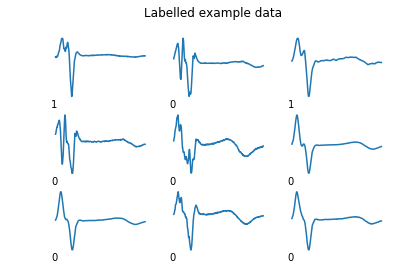

In [197]:
print(ecgData.shape)
visualiseData(ecgData, classData, 3, False)
#plt.savefig("./outData/figures/exampleDataECGundiff.pdf")

# Neural Network

In [198]:
sess = tf.InteractiveSession()
tf.reset_default_graph()
tflearn.initializations.normal()

# Input layer:
if lead == 15 or lead == 16:
    net = tflearn.layers.core.input_data(shape=[None, bufferxL*2, 1])
elif lead != 15:
    net = tflearn.layers.core.input_data(shape=[None, buffer*2, 1])

# First layer:
net = tflearn.layers.conv.conv_1d(net, 32, 5, activation="leaky_relu")
net = tflearn.layers.conv.max_pool_1d(net, 2)

# Second layer:
net = tflearn.layers.conv.conv_1d(net, 64, 5, activation="leaky_relu")
net = tflearn.layers.conv.max_pool_1d(net, 2)

# Fully connected layer 1:
net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")

# Dropout layer:
net = tflearn.layers.core.dropout(net, keep_prob=0.5)

# Output layer:
net = tflearn.layers.core.fully_connected(net, 2, activation="softmax")

net = tflearn.layers.estimator.regression(net, optimizer='adam', loss='categorical_crossentropy',\
                         learning_rate=0.00001)

In [199]:
model = tflearn.DNN(net, tensorboard_verbose=3)
model.fit(trainData, trainLabels, n_epoch=20, show_metric=True)

Training Step: 380  | total loss: 0.66483
| Adam | epoch: 020 | loss: 0.66483 - acc: 0.9420 -- iter: 1154/1154
Training Step: 380  | total loss: 0.66483
| Adam | epoch: 020 | loss: 0.66483 - acc: 0.9420 -- iter: 1154/1154
--


In [200]:
# Save model?
#now = datetime.datetime.now()
#model.save("./outData/models/cleanECG_undiff_FrankCAT_"+now.isoformat()+"_.tflearn")

# Test accuracy of model(s)

In [201]:
#model.load("./outData/models/cleanECG_undiff_20e_300buff_0shift_2017-02-21T19:20:35.702943_.tflearn")
#model.load("./outData/models/cleanECG_undiff_20e_150buff_2017-02-21T16:15:02.602923_.tflearn")
labellst = classData[:round(ecgData.shape[0]*0.2)]
healthTest = []
illTest = []
for index, item in enumerate(labellst):
    if item == 1:
        illTest.append(testData[index])
    if item == 0:
        healthTest.append(testData[index])

healthLabel = np.tile([1,0], (len(healthTest), 1))
illLabel = np.tile([0,1], (len(illTest), 1))
                      
print("Sensitivity:", model.evaluate(np.array(healthTest), healthLabel), "Specifity:",\
    model.evaluate(np.array(illTest), illLabel),\
    "Accuracy:", model.evaluate(testData, testLabels))

Sensitivity: [0.97350993377483441] Specifity: [0.92753623188405798] Accuracy: [0.95155709342560557]


### What if the model hasn't seen data from the patient?

In [202]:
till0 = importData("./inData/clean_ecg/testIll/s0177lre.txt")
till1 = importData("./inData/clean_ecg/testIll/s0110lre.txt")
till2 = importData("./inData/clean_ecg/testIll/s0088lre.txt")
till3 = importData("./inData/clean_ecg/testIll/s0130lre.txt")
till4 = importData("./inData/clean_ecg/testIll/s0100lre.txt")


thealth0 = importData("./inData/clean_ecg/testHealth/s0287lre.txt")
thealth1 = importData("./inData/clean_ecg/testHealth/s0336lre.txt")
thealth2 = importData("./inData/clean_ecg/testHealth/s0363lre.txt")
thealth3 = importData("./inData/clean_ecg/testHealth/s0457_re.txt")
thealth4 = importData("./inData/clean_ecg/testHealth/s0460_re.txt")

if 0 <= lead < 15:
    print("Selecting lead", lead)
    thealth = np.concatenate((thealth0[lead], thealth1[lead], thealth2[lead], \
                                      thealth3[lead], thealth4[lead]), axis=0)
    till = np.concatenate((till0[lead], till1[lead], till2[lead], till3[lead], \
                                   till4[lead]), axis=0)
    
    unseenData, unseenClassOH, unseenClass = functionTown(till, thealth, illThreshold, healthThreshold, \
                                                   skip, shift, buffer, shuf, avgNo)

    tillarr, thealtharr = splitData(unseenData, unseenClass)
    # Undifferentiate values
    #tillarr = undiff(tillarr, buffer)
    #thealtharr = undiff(thealtharr, buffer)
    sens = model.evaluate(np.array(thealtharr), np.tile([1,0], (len(thealtharr), 1)))[0]
    spec = model.evaluate(np.array(tillarr), np.tile([0,1], (len(tillarr), 1)))[0]
    lenh = len(thealtharr)
    leni = len(tillarr)

elif lead == 15:
    print("Outputting array with shape [15, -1]")
    thealth = np.concatenate((thealth0, thealth1, thealth2, thealth3, thealth4), axis=1)
    till = np.concatenate((till0, till1, till2, till3, till4), axis=1)
    
    unseenData, unseenClassOH, unseenClass = functionTownCat(till, thealth, illThreshold, healthThreshold, \
                                                   skip, shift, buffer, False, avgNo)

    # Undifferentiate values
    #unseenData = undiff(unseenData, bufferxL)
    tillarr, thealtharr = splitData(unseenData, unseenClass)
    
    sens = model.evaluate(np.array(thealtharr), np.tile([1,0], (len(thealtharr), 1)))[0]
    spec = model.evaluate(np.array(tillarr), np.tile([0,1], (len(tillarr), 1)))[0]
    lenh = len(thealtharr)
    leni = len(tillarr)
    visualiseData(unseenData, unseenClass, 5, True)
    
elif lead == 16:
    print("Outputing Frank leads")
    thealth = np.concatenate((thealth0[12:15], thealth1[12:15], thealth2[12:15], \
                                      thealth3[12:15], thealth4[12:15]), axis=1)
    till = np.concatenate((till0[12:15], till1[12:15], till2[12:15], till3[12:15], till4[12:15]),\
                             axis=1)
                          
    unseenData, unseenClassOH, unseenClass = functionTownCat(till, thealth, illThreshold, healthThreshold, \
                                                   skip, shift, buffer, True, avgNo)
    
    # Undifferentiate values
    unseenData = undiff(unseenData, bufferxL)
    tillarr, thealtharr = splitData(unseenData, unseenClass)
    
    sens = model.evaluate(np.array(thealtharr), np.tile([1,0], (len(thealtharr), 1)))[0]
    spec = model.evaluate(np.array(tillarr), np.tile([0,1], (len(tillarr), 1)))[0]
    lenh = len(thealtharr)
    leni = len(tillarr)
    visualiseData(unseenData, unseenClass, 5, True)                       
    
else:
    print("Lead says", lead, "so selecting whole thing")
    thealth = np.hstack(np.concatenate((thealth0, thealth1, thealth2, thealth3, thealth4), axis=1))
    till = np.hstack(np.concatenate((till0, till1, till2, till3, till4), axis=1))
    
    tillarr, tillclassOH, tillclassData = functionTown(till, thealth, illThreshold, healthThreshold, \
                                                   skip, shift, buffer, shuf, avgNo)
    thealtharr, thealthclassOH, thealthclassData = functionTown([0], thealth, illThreshold, \
                                                            healthThreshold, skip, shift, buffer, shuf, avgNo)

    # Undifferentiate values
    #tillarr = undiff(tillarr, buffer)
    #thealtharr = undiff(thealtharr, buffer)
    sens = model.evaluate(thealtharr, thealthclassOH)[0]
    spec = model.evaluate(tillarr, tillclassOH)[0]
    lenh = thealtharr.shape[0]
    leni = tillarr.shape[0]

print("Sensitivity:", sens,\
      "Specifity:", spec,\
      "Accuracy:", ((sens*lenh+spec*leni)/(lenh+leni)))

Shape: (15, 115199)
Shape: (15, 115199)
Shape: (15, 115199)
Shape: (15, 115199)
Shape: (15, 115199)
Shape: (15, 115199)
Shape: (15, 115199)
Shape: (15, 115199)
Shape: (15, 120011)
Shape: (15, 120011)
Selecting lead 12
ill samples 27687
healthy samples 27531
(553,)
Avgd ill samples: (553, 400)
Avgd healthy samples: (550, 400)
Sensitivity: 0.707272726406 Specifity: 0.770343578314 Accuracy: 0.738893924144
